## Download Data

In [2]:
# !gdown --fuzzy 'https://drive.google.com/file/d/1mqtONldpayaQ97SH1p_UfdoH6nywVfYt/view?usp=sharing'

Downloading...
From: https://drive.google.com/uc?id=1mqtONldpayaQ97SH1p_UfdoH6nywVfYt
To: /root/data-flywheel/notebooks/detection_results_validation.parquet
100%|██████████████████████████████████████| 1.39M/1.39M [00:00<00:00, 4.99MB/s]


In [3]:
import pandas as pd

df = pd.read_parquet('detection_results_validation.parquet')
df

filename  classid     score  \
0       /workspace/yolo_v8_training/oiv7_full/validati...        0  0.971191   
1       /workspace/yolo_v8_training/oiv7_full/validati...        0  0.963867   
2       /workspace/yolo_v8_training/oiv7_full/validati...        0  0.945312   
3       /workspace/yolo_v8_training/oiv7_full/validati...        1  0.931641   
4       /workspace/yolo_v8_training/oiv7_full/validati...        1  0.916992   
...                                                   ...      ...       ...   
142674  /workspace/yolo_v8_training/oiv7_full/validati...        3  0.865234   
142675  /workspace/yolo_v8_training/oiv7_full/validati...        0  0.922852   
142676  /workspace/yolo_v8_training/oiv7_full/validati...        1  0.859863   
142677  /workspace/yolo_v8_training/oiv7_full/validati...        2  0.640625   
142678  /workspace/yolo_v8_training/oiv7_full/validati...        3  0.447754   

         x1   y1    x2   y2  
0        20   99   336  604  
1       342    0   664  609  
2       698  166  1008  864  
3       496    0   587   86  
4        50   91   123  185  
...     ...  ...   ...  ...  
142674  317  273   347  319  
142675  209  467   280  578  
142676  213  464   253  501  
142677  265  493   284  510  
142678  232  472   249  493  

[142679 rows x 7 columns]

In [4]:
df = df[df['classid'] == 0] # only get rows with class 0 person.
df.loc[df['classid'] == 0, 'classid'] = 'person'
df

<ipython-input-4-01a8ec3d4884>:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'person' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df['classid'] == 0, 'classid'] = 'person'


filename classid     score  \
0       /workspace/yolo_v8_training/oiv7_full/validati...  person  0.971191   
1       /workspace/yolo_v8_training/oiv7_full/validati...  person  0.963867   
2       /workspace/yolo_v8_training/oiv7_full/validati...  person  0.945312   
13      /workspace/yolo_v8_training/oiv7_full/validati...  person  0.889648   
14      /workspace/yolo_v8_training/oiv7_full/validati...  person  0.941406   
...                                                   ...     ...       ...   
142662  /workspace/yolo_v8_training/oiv7_full/validati...  person  0.958496   
142667  /workspace/yolo_v8_training/oiv7_full/validati...  person  0.889160   
142669  /workspace/yolo_v8_training/oiv7_full/validati...  person  0.789551   
142672  /workspace/yolo_v8_training/oiv7_full/validati...  person  0.941895   
142675  /workspace/yolo_v8_training/oiv7_full/validati...  person  0.922852   

         x1   y1    x2    y2  
0        20   99   336   604  
1       342    0   664   609  
2       698  166  1008   864  
13      740    0   956   261  
14      213    0  1020   666  
...     ...  ...   ...   ...  
142662   13    9   728  1024  
142667  371  445   421   593  
142669  268  124   300   148  
142672  242  252   374   576  
142675  209  467   280   578  

[50529 rows x 7 columns]

In [5]:
df = df.head(1000)

## Convert Data to VOC format

In [6]:
import os
import xml.etree.ElementTree as ET
import pandas as pd

def create_voc_xml(filename, objects, output_dir):
    # Create the root element
    annotation = ET.Element('annotation')

    # Add the filename element
    filename_elem = ET.SubElement(annotation, 'filename')
    filename_elem.text = os.path.basename(filename)

    # Add the size element (assuming a fixed size, you can modify this according to your needs)
    size = ET.SubElement(annotation, 'size')
    width = ET.SubElement(size, 'width')
    width.text = '1024'  # Replace with the actual width of your image
    height = ET.SubElement(size, 'height')
    height.text = '1024'  # Replace with the actual height of your image
    depth = ET.SubElement(size, 'depth')
    depth.text = '3'

    # Add the object elements
    for obj in objects:
        obj_elem = ET.SubElement(annotation, 'object')
        name = ET.SubElement(obj_elem, 'name')
        name.text = str(obj['classid'])
        pose = ET.SubElement(obj_elem, 'pose')
        pose.text = 'Unspecified'
        truncated = ET.SubElement(obj_elem, 'truncated')
        truncated.text = '0'
        difficult = ET.SubElement(obj_elem, 'difficult')
        difficult.text = '0'
        bndbox = ET.SubElement(obj_elem, 'bndbox')
        xmin = ET.SubElement(bndbox, 'xmin')
        xmin.text = str(obj['x1'])
        ymin = ET.SubElement(bndbox, 'ymin')
        ymin.text = str(obj['y1'])
        xmax = ET.SubElement(bndbox, 'xmax')
        xmax.text = str(obj['x2'])
        ymax = ET.SubElement(bndbox, 'ymax')
        ymax.text = str(obj['y2'])

    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Generate the output file path
    output_file = os.path.join(output_dir, os.path.splitext(os.path.basename(filename))[0] + '.xml')

    # Write the XML to the output file
    tree = ET.ElementTree(annotation)
    tree.write(output_file, encoding='utf-8', xml_declaration=True)


output_directory = 'pascal_voc_annotations'

grouped_df = df.groupby('filename').apply(lambda x: x.to_dict('records')).reset_index(name='objects')

for _, row in grouped_df.iterrows():
    filename = row['filename']
    objects = row['objects']
    create_voc_xml(filename, objects, output_directory)

<ipython-input-6-0ab6d6c2f496>:56: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_df = df.groupby('filename').apply(lambda x: x.to_dict('records')).reset_index(name='objects')


## Plot XML to verify conversion is correct

In [7]:
import cv2
import matplotlib.pyplot as plt

def plot_image_with_bounding_boxes(xml_path, image_folder):
    # Parse the XML file
    tree = ET.parse(xml_path)
    root = tree.getroot()

    # Get the image filename from the XML
    image_filename = root.find('filename').text
    image_path = os.path.join(image_folder, image_filename)

    # Read the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Extract the bounding box information
    for obj in root.findall('object'):
        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        class_id = obj.find('name').text

        # Draw the bounding box on the image
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

        # Put the class ID text above the bounding box
        cv2.putText(image, class_id, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    # Display the image with bounding boxes and class IDs
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

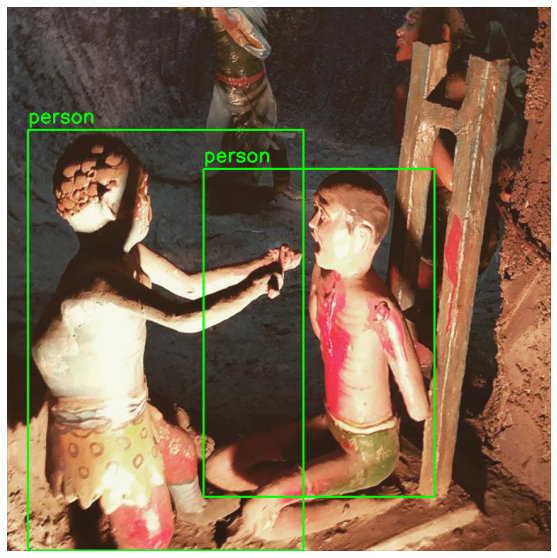

In [8]:
image_folder = '/workspace/yolo_v8_training/oiv7_full/validation/'
xml_path = 'pascal_voc_annotations/011417767312812e.xml'
plot_image_with_bounding_boxes(xml_path, image_folder)

# {0: 'person', 1: 'head', 2: 'hand', 3: 'face'}

## Load Into IceVision

In [9]:
from icevision.all import *

parser = parsers.VOCBBoxParser(annotations_dir='pascal_voc_annotations/', 
                               images_dir='/workspace/yolo_v8_training/oiv7_full/validation/')

/root/miniforge-pypy3/envs/icevision/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO     - The mmdet config folder already exists. No need to downloaded it. Path : /root/.icevision/mmdetection_configs/mmdetection_configs-2.20.1/configs | icevision.models.mmdet.download_configs:download_mmdet_configs:17


In [10]:
# Parse annotations to create records
train_records, valid_records = parser.parse() # Defaults to 80:20 split
parser.class_map

100%|██████████| 242/242 [00:00<00:00, 3230.61it/s]
INFO     - Autofixing records | icevision.parsers.parser:parse:122
  0%|          | 0/242 [00:00<?, ?it/s]AUTOFIX-SUCCESS - (record_id: 018bbadd96337150) - Clipping bbox xmax from 1160 to image width 1024 (Before: <BBox (xmin:890, ymin:855, xmax:1160, ymax:1036)>) | icevision.utils.logger_utils:autofix_log:17
AUTOFIX-SUCCESS - (record_id: 018bbadd96337150) - Clipping bbox ymax from 1036 to image height 1024 (Before: <BBox (xmin:890, ymin:855, xmax:1024, ymax:1036)>) | icevision.utils.logger_utils:autofix_log:17
100%|██████████| 242/242 [00:00<00:00, 1503.60it/s]


<ClassMap: {'background': 0, 'person': 1}>

In [11]:
image_size = 384
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=image_size, presize=512), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(image_size), tfms.A.Normalize()])

In [12]:
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

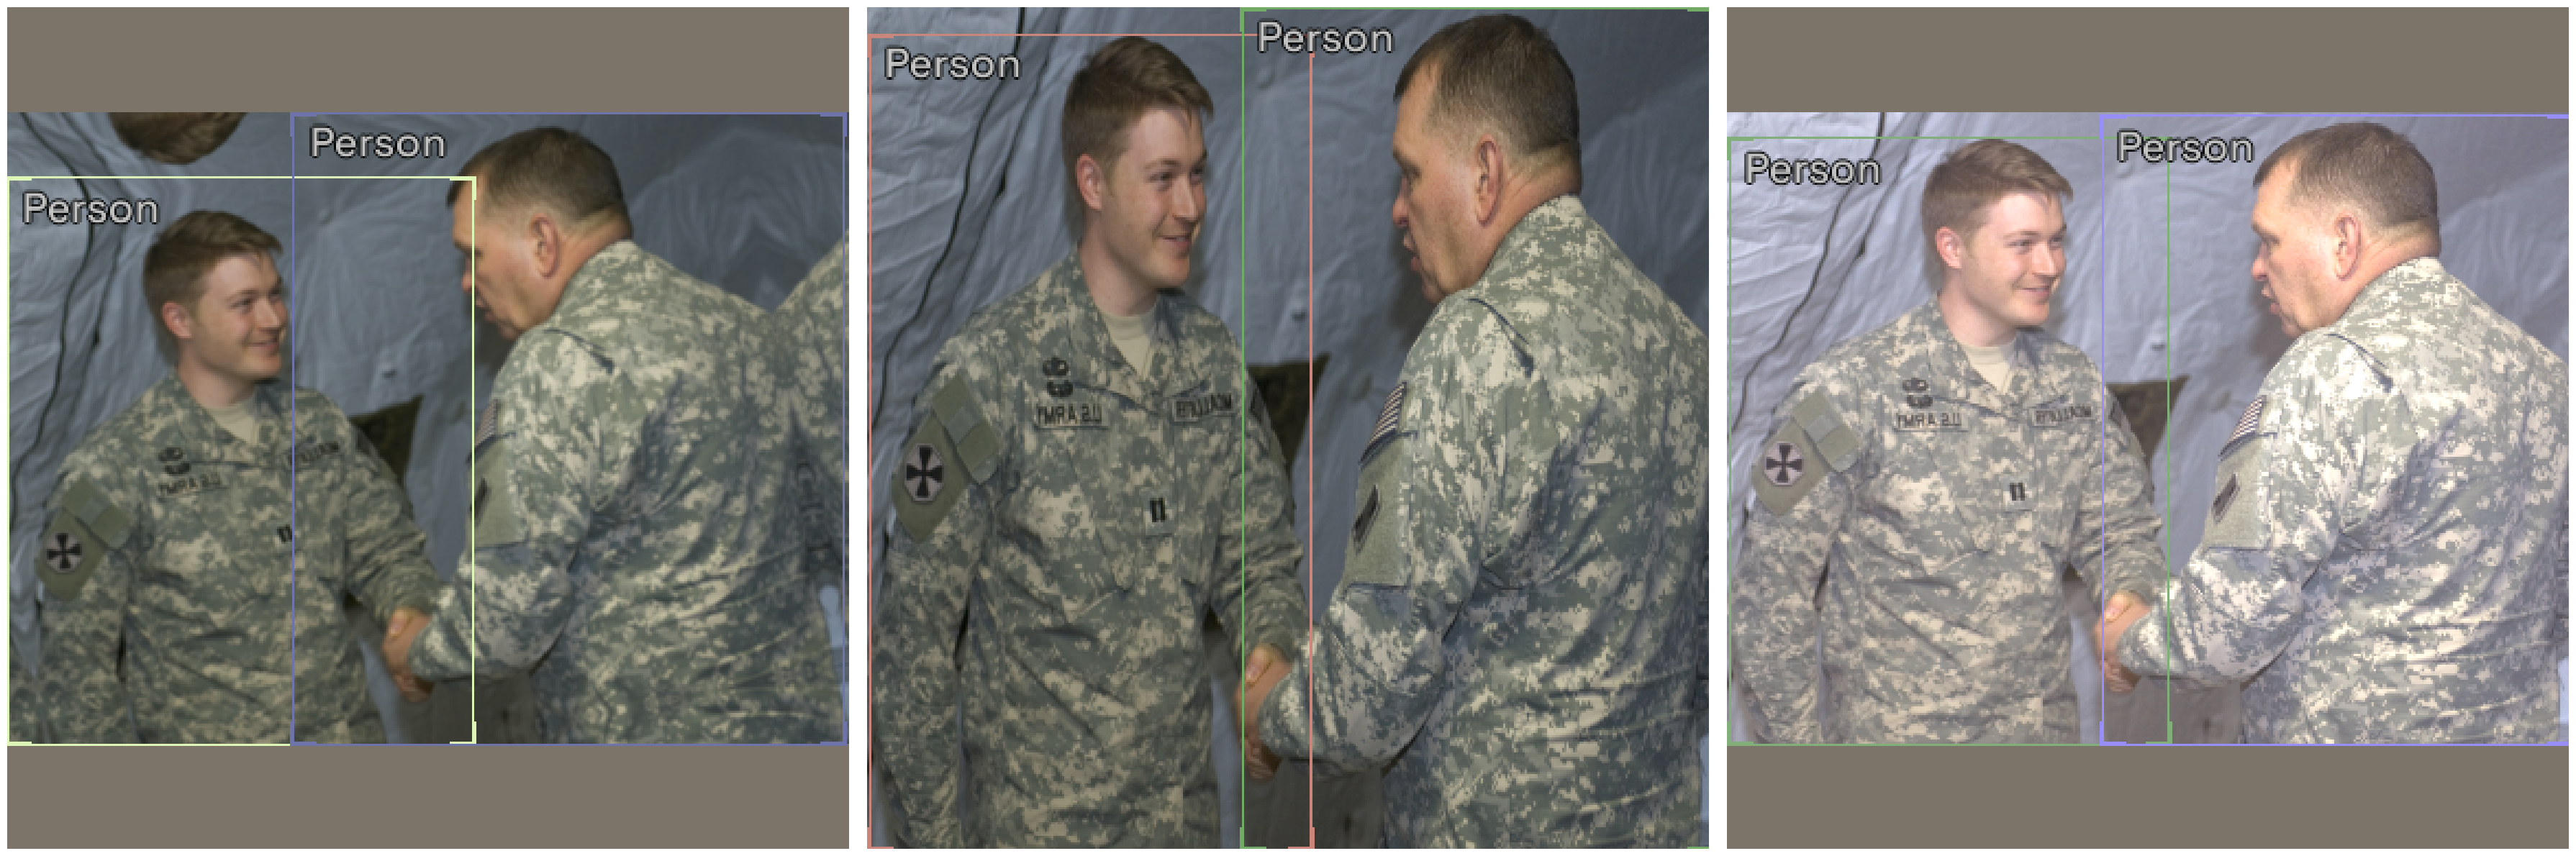

In [13]:
%matplotlib inline
# Show an element of the train_ds with augmentation transformations applied
samples = [train_ds[0] for _ in range(3)]
show_samples(samples, ncols=3)

In [15]:
extra_args = {}
model_type = models.mmdet.vfnet
backbone = model_type.backbones.resnet50_fpn_mstrain_2x
model = model_type.model(backbone=backbone(pretrained=True), num_classes=len(parser.class_map), **extra_args) 


100%|██████████| 131902412/131902412 [00:07<00:00, 17119394.64B/s]
/root/miniforge-pypy3/envs/icevision/lib/python3.9/site-packages/mmdet/core/anchor/builder.py:16: UserWarning: ``build_anchor_generator`` would be deprecated soon, please use ``build_prior_generator`` 
  warnings.warn(
2024-03-11 13:53:37,628 - mmcv - INFO - initialize ResNet with init_cfg {'type': 'Pretrained', 'checkpoint': 'torchvision://resnet50'}
2024-03-11 13:53:37,629 - mmcv - INFO - load model from: torchvision://resnet50
2024-03-11 13:53:37,630 - mmcv - INFO - load checkpoint from torchvision path: torchvision://resnet50
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 44.5MB/s]
2024-03-11 13:53:40,420 - mmcv - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

2024-03-11 13:53:40,434 - mmcv - INFO - initialize FPN wi

load checkpoint from local path: checkpoints/vfnet/vfnet_r50_fpn_mstrain_2x_coco_20201027-7cc75bd2.pth
The model and loaded state dict do not match exactly

size mismatch for bbox_head.vfnet_cls.weight: copying a param with shape torch.Size([80, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([1, 256, 3, 3]).
size mismatch for bbox_head.vfnet_cls.bias: copying a param with shape torch.Size([80]) from checkpoint, the shape in current model is torch.Size([1]).


In [16]:
# Data Loaders
train_dl = model_type.train_dl(train_ds, batch_size=8, num_workers=4, shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=8, num_workers=4, shuffle=False)

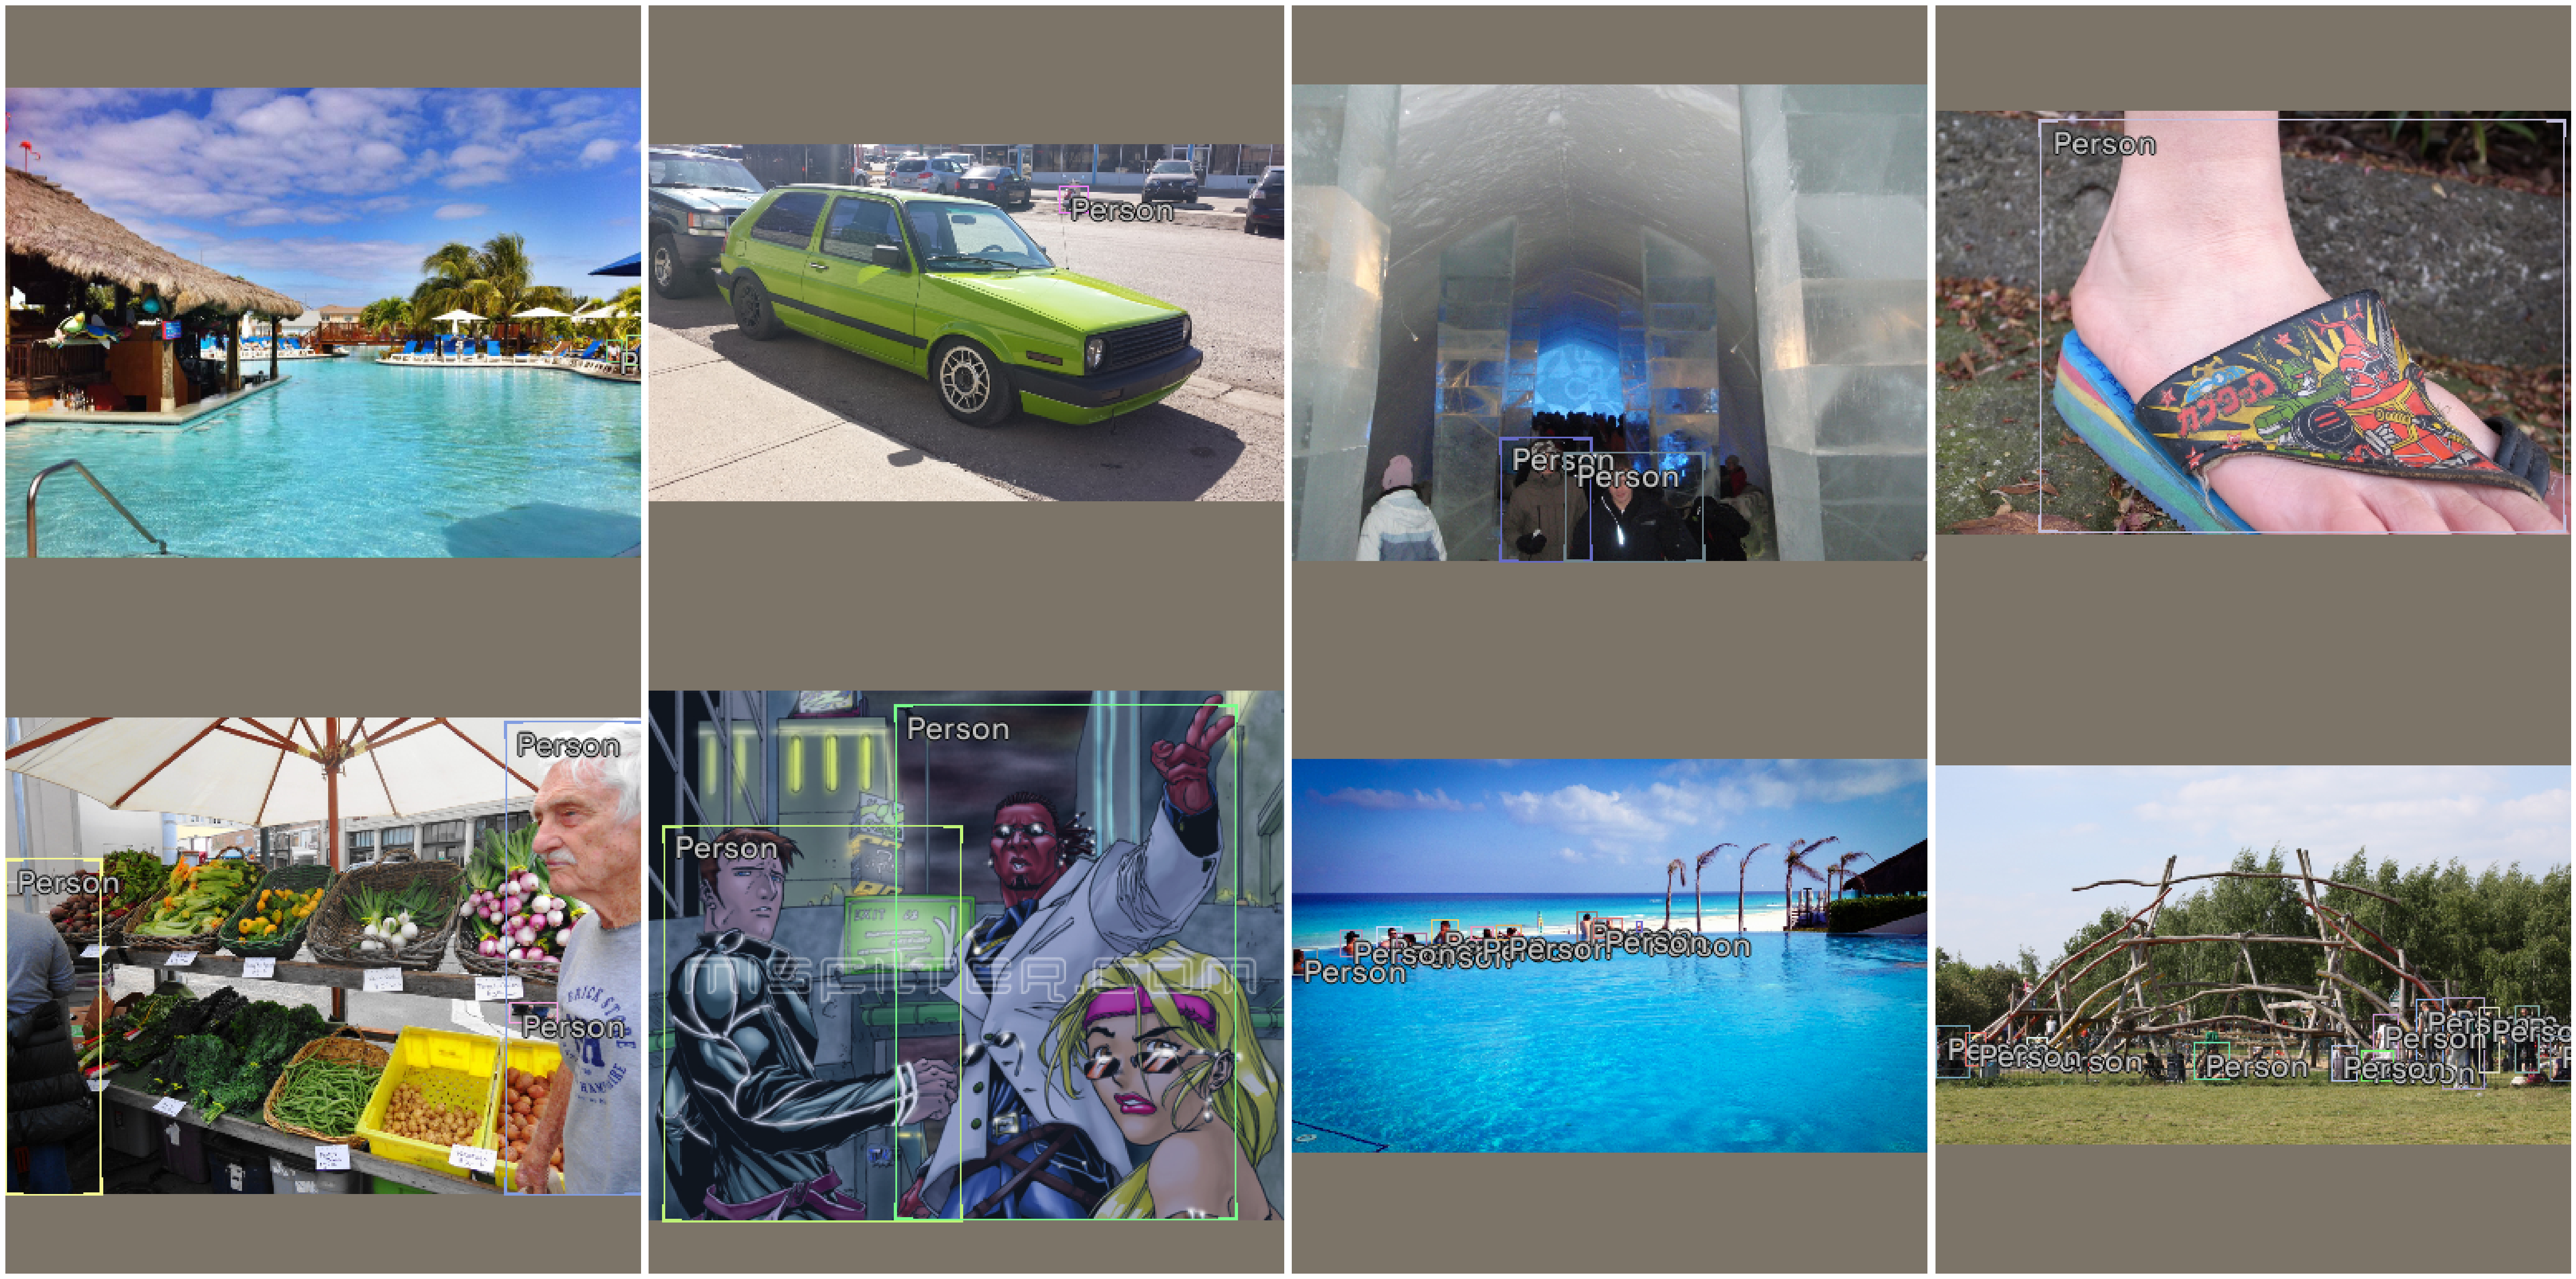

In [17]:
# show batch
model_type.show_batch(first(valid_dl), ncols=4)

In [18]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

learn = model_type.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics)

/root/miniforge-pypy3/envs/icevision/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180487213/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/root/miniforge-pypy3/envs/icevision/lib/python3.9/site-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/root/miniforge-pypy3/envs/icevision/lib/python3.9/site-packages/mmdet/core/anchor/anchor_generator.py:360: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  warnings.warn(


SuggestedLRs(valley=0.0005754399462603033)

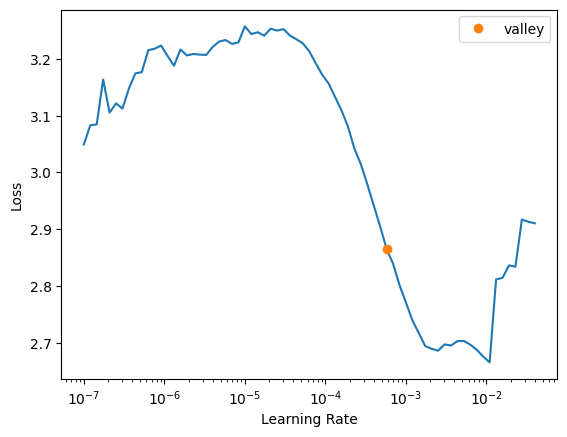

In [19]:
learn.lr_find()

In [20]:
learn.fine_tune(10, 0.001, freeze_epochs=3)

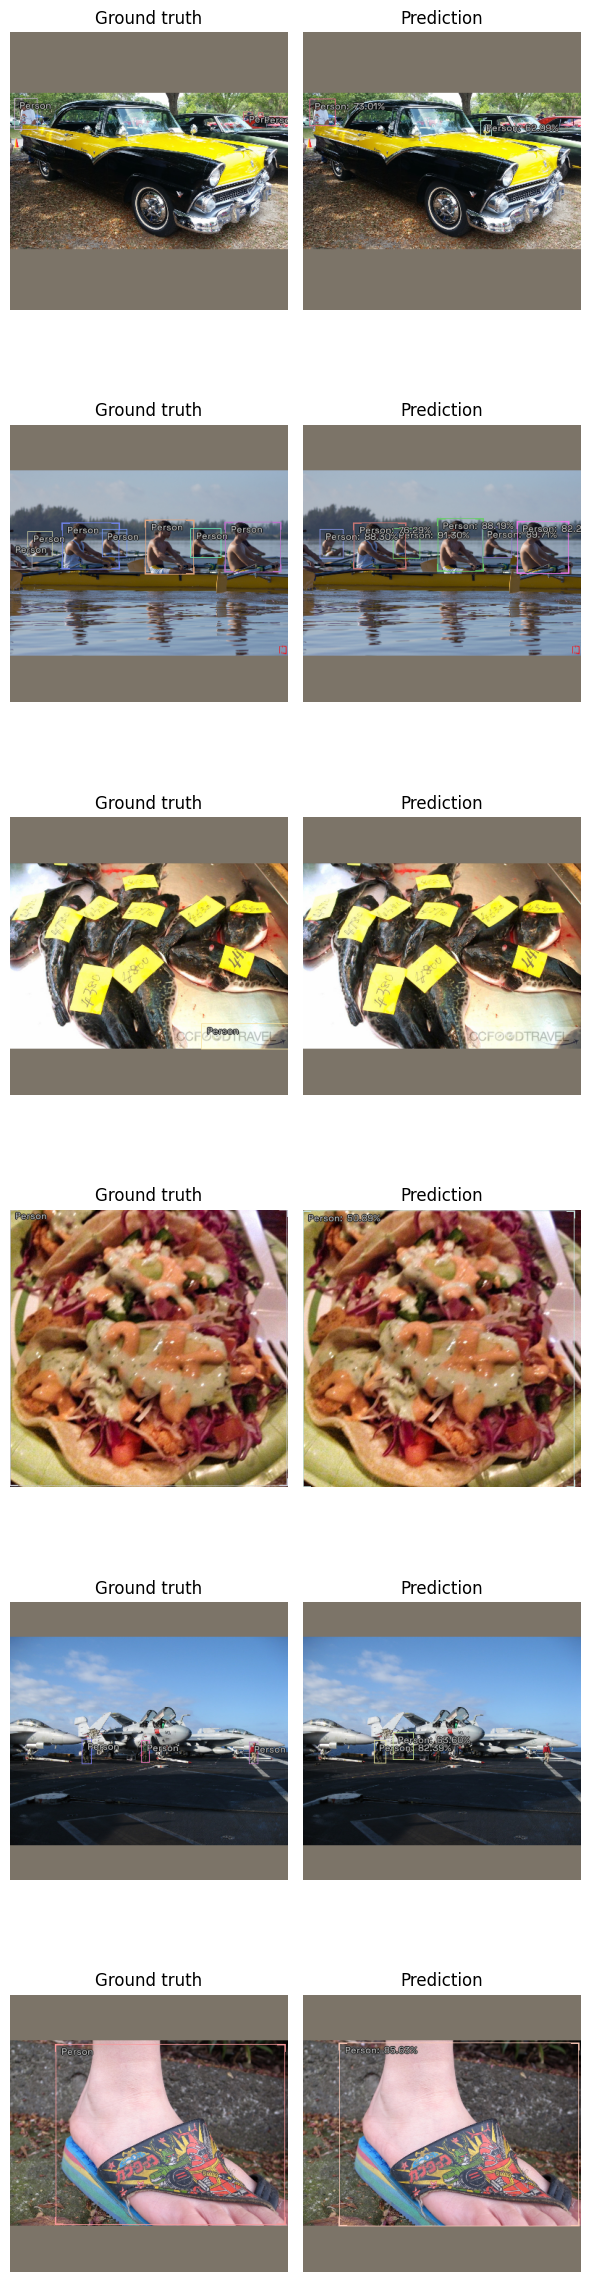

In [21]:
model_type.show_results(model, valid_ds, detection_threshold=.5)

INFO     - Losses returned by model: ['loss_cls', 'loss_bbox'] | icevision.models.interpretation:plot_top_losses:219
100%|██████████| 7/7 [00:02<00:00,  2.62it/s]


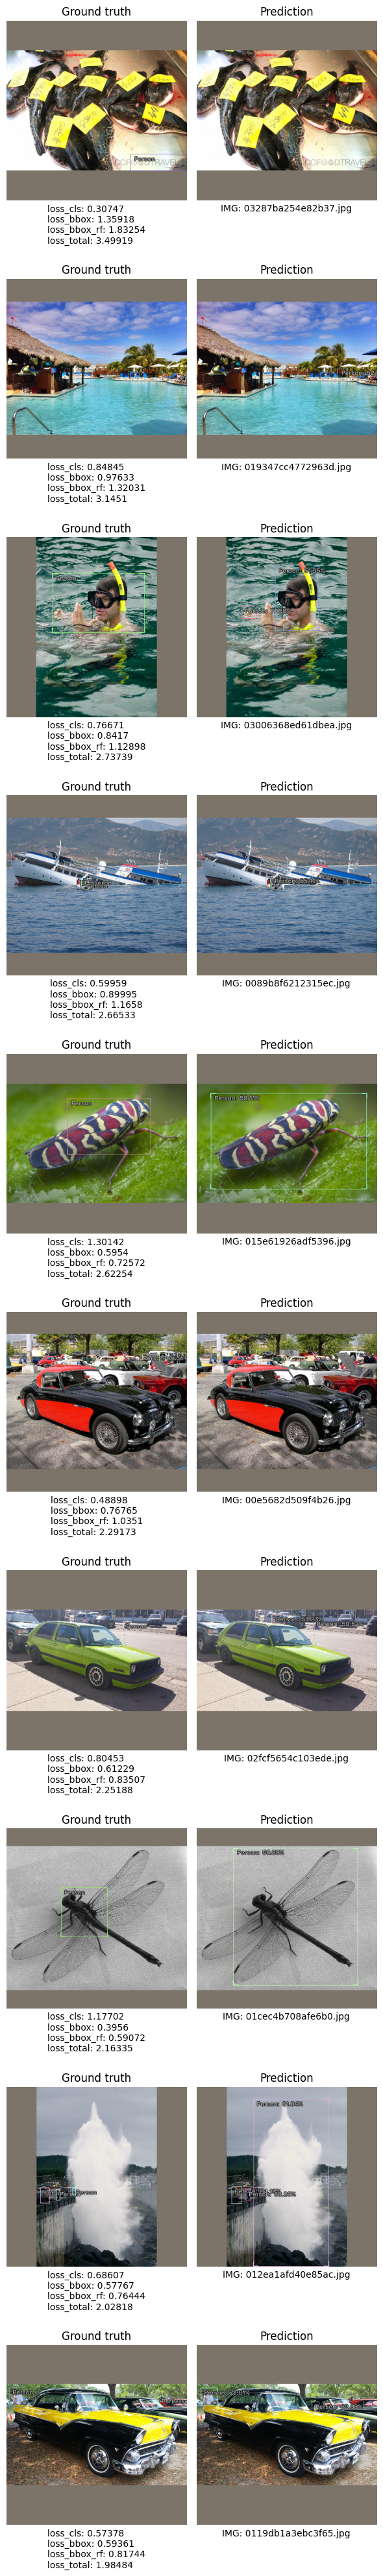

In [22]:
sorted_samples, sorted_preds, losses_stats = model_type.interp.plot_top_losses(model, valid_ds, sort_by="loss_total", n_samples=10)

In [23]:
from icevision.models.checkpoint import *
save_icevision_checkpoint(model,
                        model_name='mmdet.vfnet', 
                        backbone_name='resnet50_fpn_mstrain_2x',
                        img_size=640,
                        classes=parser.class_map.get_classes(),
                        filename='./models/model_checkpoint.pth',
                        meta={'icevision_version': '0.12.0'})